## 1. Cargar y explorar la base de datos de cabildos

Objetivo: Revisar qu√© columnas tienes (probablemente concepto, fundamento, region, etc.) y filtrar solo los registros relevantes.

In [23]:
import pandas as pd

df = pd.read_excel(r"C:\Entorno_Desarrollo\UDD\Procesamiento_NPL\Procesamiento-LN\Lab1_NLP\data\resultadocabildoprovincial.xlsx", sheet_name='registros')
df.head()

df['concepto_nombre'].value_counts()

concepto_nombre
Otro                                7121
Igualdad                             649
Justicia                             619
A la salud                           614
A la educaci√≥n                       611
                                    ... 
De petici√≥n ante las autoridades       2
Reuni√≥n pac√≠fica                       2
Emprendimiento libre                   1
Libertad ambulatoria                   1
Patriotismo                            1
Name: count, Length: 113, dtype: int64

## 2. Preprocesamiento de texto

Objetivo: Limpiar los textos para crear tokens listos para an√°lisis.

- Pasos clave:

- Convertir a min√∫sculas.

- Eliminar puntuaci√≥n, stopwords, tildes y caracteres especiales.

- Tokenizar con nltk o spaCy (te recomiendo spaCy, por las etiquetas gramaticales POS).

- Filtrar por tipo de palabra (por ejemplo, sustantivos).

In [24]:
import spacy
nlp = spacy.load("es_core_news_sm")

def preprocesar_texto(texto):
    doc = nlp(texto.lower())
    tokens = [token.lemma_ for token in doc 
                if token.is_alpha and not token.is_stop]
    return tokens

df['tokens'] = df['fundamento'].apply(preprocesar_texto)


## 3. WordCloud con sustantivos

In [25]:
# Verificar el contenido del dataframe
print("Columnas disponibles:", df.columns.tolist())
print("\nPrimeras filas de 'fundamento':")
print(df['fundamento'].head(3))
print("\nTipo de datos de 'fundamento':")
print(df['fundamento'].dtype)
print("\nValores nulos en 'fundamento':")
print(df['fundamento'].isnull().sum())

Columnas disponibles: ['region_nombre', 'provincia_nombre', 'comuna_nombre', 'cabildo_id', 'cabildo_nombre', 'cabildo_direccion', 'num_mesa', 'pregunta_glosa', 'concepto_nombre', 'concepto_otro', 'tipo-eleccion', 'fundamento', 'tokens']

Primeras filas de 'fundamento':
0                                       sin fundamento
1                                       Sin fundamento
2    La descentralizacion de ser autonoma por ser z...
Name: fundamento, dtype: object

Tipo de datos de 'fundamento':
object

Valores nulos en 'fundamento':
0


In [26]:
def bigramas_sust_adj(texto):
    """
    extraer bigramas de sustantivos y adjetivos
    """
    # Verificar que el texto no est√© vac√≠o o sea solo "sin fundamento"
    if pd.isna(texto) or texto.lower().strip() in ['sin fundamento', 'nan', '']:
        return []
    
    doc = nlp(str(texto).lower())
    
    # Extraer solo sustantivos y adjetivos no stopwords
    tokens_relevantes = [token.lemma_ for token in doc 
                        if (token.pos_ in ["NOUN", "ADJ"]) and 
                            token.is_alpha and 
                            not token.is_stop and 
                            len(token.lemma_) > 2]
    
    # Crear bigramas (pares de palabras consecutivas)
    bigramas = []
    for i in range(len(tokens_relevantes) - 1):
        bigrama = f"{tokens_relevantes[i]} {tokens_relevantes[i+1]}"
        bigramas.append(bigrama)
    
    return bigramas

# Probar con un texto que tenga contenido real
textos_ejemplo = df[~df['fundamento'].str.contains('sin fundamento', case=False, na=False)]['fundamento'].head(3)
print("Textos de ejemplo (que no son 'sin fundamento'):")
for i, texto in enumerate(textos_ejemplo):
    print(f"\n{i+1}. {texto[:100]}...")
    bigramas = bigramas_sust_adj(texto)
    print(f"   Bigramas extra√≠dos: {bigramas[:5]}")  # Primeros 5 bigramas

Textos de ejemplo (que no son 'sin fundamento'):

1. La descentralizacion de ser autonoma por ser zona extrema del pais...
   Bigramas extra√≠dos: ['descentralizacion zona', 'zona extremo', 'extremo pais']

2. Sin furdamento...
   Bigramas extra√≠dos: []

3. Sin furdamento...
   Bigramas extra√≠dos: []


Extrayendo bigramas de todos los textos...
Total de bigramas extra√≠dos: 88563
Bigramas √∫nicos: 50963

Bigramas m√°s frecuentes:
  acta fundamento: 335
  recurso natural: 281
  derechos humanos: 245
  pueblo originario: 212
  derecho vida: 208
  derecho fundamental: 200
  derecho deber: 183
  campo vac√≠o: 175
  gratuito calidad: 169
  participaci√≥n ciudadano: 158
Total de bigramas extra√≠dos: 88563
Bigramas √∫nicos: 50963

Bigramas m√°s frecuentes:
  acta fundamento: 335
  recurso natural: 281
  derechos humanos: 245
  pueblo originario: 212
  derecho vida: 208
  derecho fundamental: 200
  derecho deber: 183
  campo vac√≠o: 175
  gratuito calidad: 169
  participaci√≥n ciudadano: 158


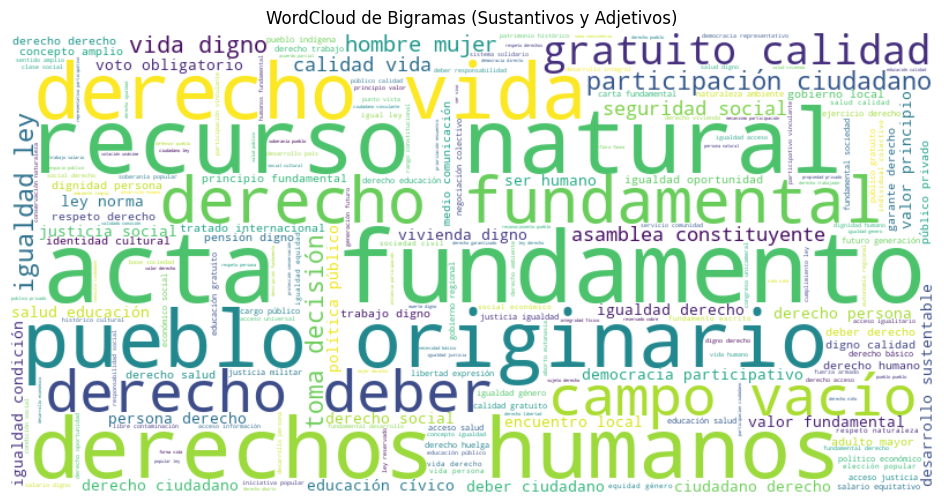

In [27]:
from collections import Counter

# Extraer todos los bigramas de sustantivos y adjetivos del dataframe
print("Extrayendo bigramas de todos los textos...")
bigramas = sum(df['fundamento'].apply(bigramas_sust_adj), [])

print(f"Total de bigramas extra√≠dos: {len(bigramas)}")
print(f"Bigramas √∫nicos: {len(set(bigramas))}")

# Mostrar los bigramas m√°s frecuentes
contador_bigramas = Counter(bigramas)
print("\nBigramas m√°s frecuentes:")
for bigrama, freq in contador_bigramas.most_common(10):
    print(f"  {bigrama}: {freq}")

# Generar WordCloud solo si hay bigramas
if bigramas:
    wc_bigramas = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(contador_bigramas)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc_bigramas, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud de Bigramas (Sustantivos y Adjetivos)')
    plt.show()
else:
    print("No se encontraron bigramas para generar el WordCloud")

üìä Resultados obtenidos:

* 88,563 bigramas extra√≠dos en total
* 50,963 bigramas √∫nicos
WordCloud generado exitosamente mostrando los bigramas m√°s frecuentes

üîç Bigramas m√°s frecuentes encontrados:

* acta fundamento: 335 veces
* recurso natural: 281 veces
* derechos humanos: 245 veces
* pueblo originario: 212 veces
* derecho vida: 208 veces
* derecho fundamental: 200 veces

üõ†Ô∏è Qu√© hace la funci√≥n bigramas_sust_adj:
1. Filtra textos v√°lidos (excluye "sin fundamento")
2. Extrae sustantivos y adjetivos usando spaCy
3. Elimina stopwords y palabras muy cortas
4. Crea bigramas (pares de palabras consecutivas)
5. Retorna la lista de bigramas

## 5. Red de bigramas

Puedes usar networkx para construir y visualizar:

Creando grafo con los 30 bigramas m√°s frecuentes...
Bigramas seleccionados (frecuencia >= 50):
  acta fundamento: 335
  recurso natural: 281
  derechos humanos: 245
  pueblo originario: 212
  derecho vida: 208
  derecho fundamental: 200
  derecho deber: 183
  campo vac√≠o: 175
  gratuito calidad: 169
  participaci√≥n ciudadano: 158
  igualdad ley: 156
  toma decisi√≥n: 136
  vida digno: 129
  hombre mujer: 122
  asamblea constituyente: 120
  calidad vida: 118
  seguridad social: 114
  democracia participativo: 110
  valor principio: 109
  igualdad derecho: 108
  derecho persona: 107
  derecho social: 103
  educaci√≥n c√≠vico: 102
  desarrollo sustentable: 99
  vivienda digno: 96
  valor fundamental: 91
  persona derecho: 87
  justicia social: 82
  derecho ciudadano: 80
  ciudadano derecho: 80

Grafo creado con 40 nodos y 28 conexiones


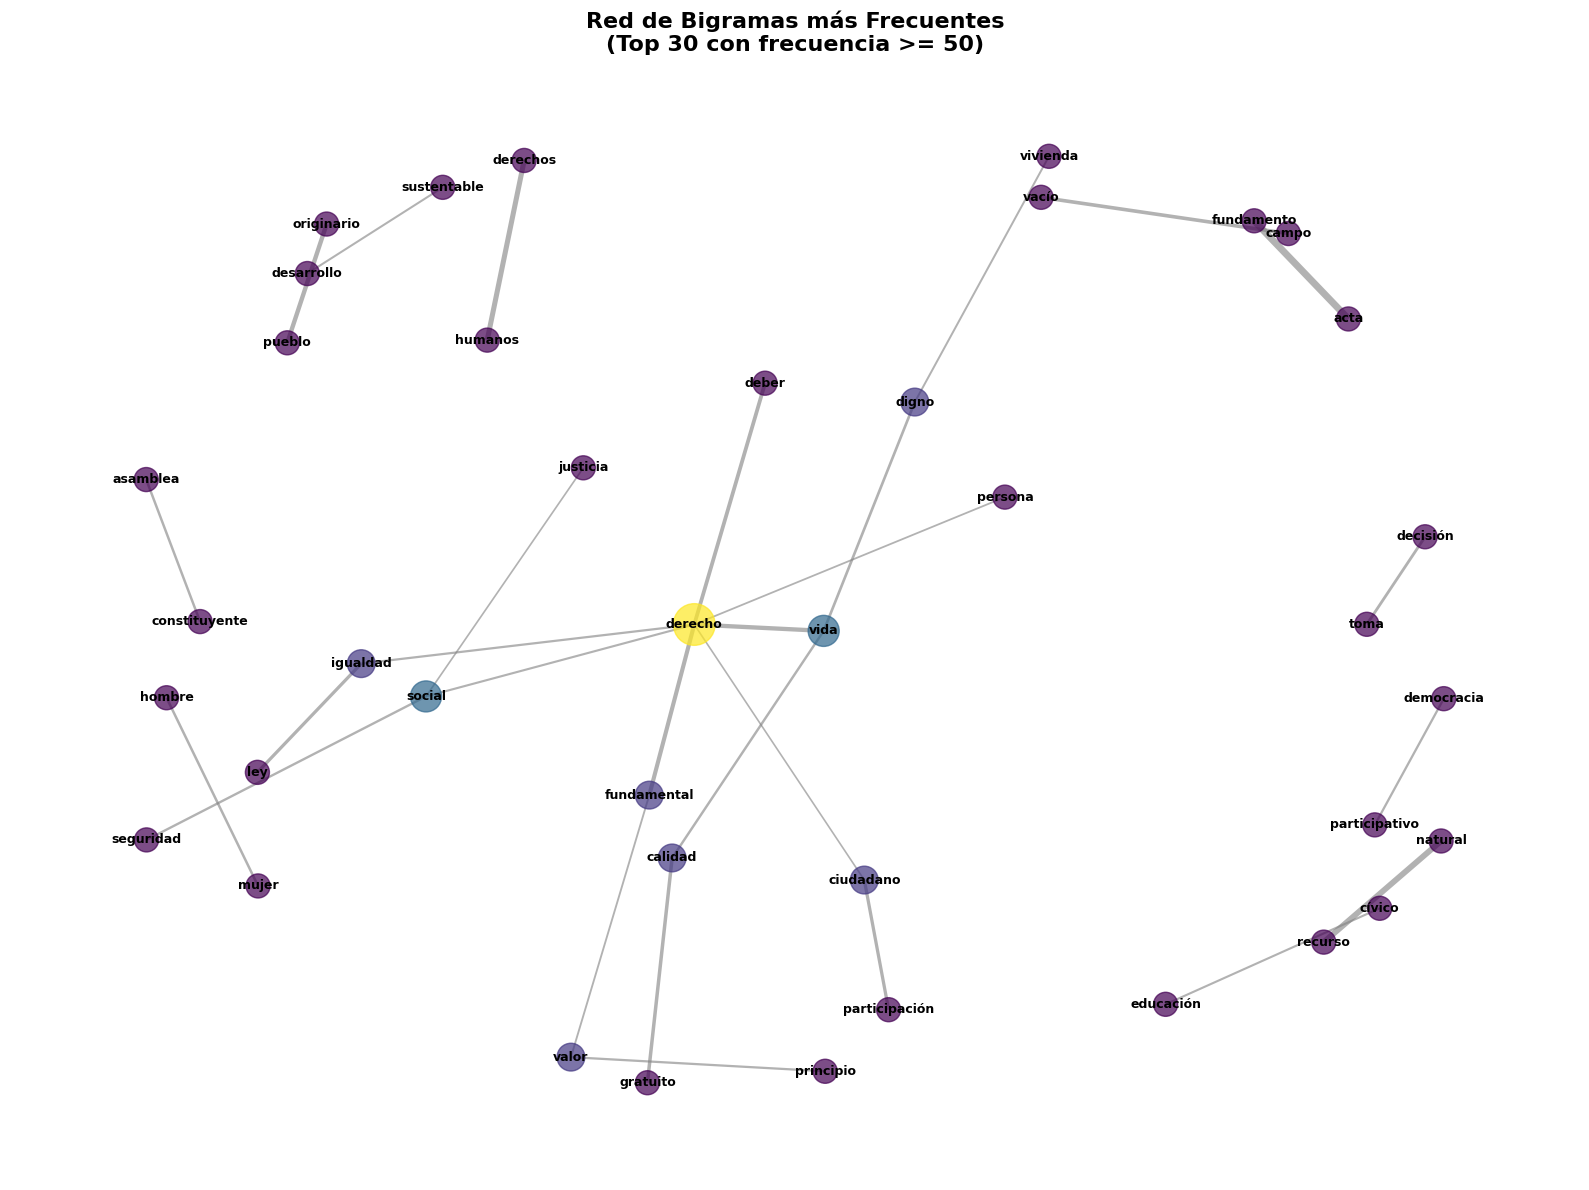


üìä Estad√≠sticas del grafo:
  ‚Ä¢ Nodos: 40
  ‚Ä¢ Conexiones: 28
  ‚Ä¢ Densidad: 0.036

üîç Palabras m√°s conectadas (centrales):
  ‚Ä¢ derecho: 0.179 (7 conexiones)
  ‚Ä¢ vida: 0.077 (3 conexiones)
  ‚Ä¢ social: 0.077 (3 conexiones)
  ‚Ä¢ fundamental: 0.051 (2 conexiones)
  ‚Ä¢ calidad: 0.051 (2 conexiones)


In [33]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Configurar par√°metros para el filtrado
TOP_BIGRAMAS = 30  # N√∫mero de bigramas m√°s frecuentes a mostrar
FRECUENCIA_MINIMA = 50  # Frecuencia m√≠nima para incluir un bigrama

print(f"Creando grafo con los {TOP_BIGRAMAS} bigramas m√°s frecuentes...")

# Filtrar solo los bigramas m√°s frecuentes
bigramas_filtrados = contador_bigramas.most_common(TOP_BIGRAMAS)
print(f"Bigramas seleccionados (frecuencia >= {FRECUENCIA_MINIMA}):")

# Crear el grafo
G = nx.Graph()
pesos_edges = {}

for bigrama, count in bigramas_filtrados:
    if count >= FRECUENCIA_MINIMA:  # Solo incluir si tiene frecuencia alta
        try:
            palabras = bigrama.split()
            if len(palabras) == 2:  # Asegurar que es un bigrama v√°lido
                a, b = palabras
                G.add_edge(a, b, weight=count)
                pesos_edges[(a, b)] = count
                print(f"  {bigrama}: {count}")
        except ValueError:
            continue

print(f"\nGrafo creado con {G.number_of_nodes()} nodos y {G.number_of_edges()} conexiones")

# Configurar el layout y visualizaci√≥n
plt.figure(figsize=(16, 12))

# Usar spring layout para mejor distribuci√≥n
pos = nx.spring_layout(G, k=3, iterations=50)

# Calcular tama√±os de nodos basados en su grado (n√∫mero de conexiones)
node_sizes = [G.degree(node) * 100 + 200 for node in G.nodes()]

# Calcular colores basados en centralidad
centrality = nx.degree_centrality(G)
node_colors = [centrality[node] for node in G.nodes()]

# Dibujar el grafo
nx.draw_networkx_nodes(G, pos, 
                      node_size=node_sizes,
                      node_color=node_colors,
                      cmap=plt.cm.viridis,
                      alpha=0.7)

nx.draw_networkx_labels(G, pos, 
                       font_size=9,
                       font_weight='bold',
                       font_color='black')

# Dibujar edges con grosor proporcional al peso
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1

nx.draw_networkx_edges(G, pos,
                      width=[w/max_weight * 5 for w in weights],
                      alpha=0.6,
                      edge_color='gray')

plt.title(f'Red de Bigramas m√°s Frecuentes\n(Top {len(bigramas_filtrados)} con frecuencia >= {FRECUENCIA_MINIMA})', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Mostrar estad√≠sticas del grafo
print(f"\nüìä Estad√≠sticas del grafo:")
print(f"  ‚Ä¢ Nodos: {G.number_of_nodes()}")
print(f"  ‚Ä¢ Conexiones: {G.number_of_edges()}")
print(f"  ‚Ä¢ Densidad: {nx.density(G):.3f}")

# Mostrar los nodos m√°s conectados (centrales)
if G.number_of_nodes() > 0:
    degree_centrality = nx.degree_centrality(G)
    top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nüîç Palabras m√°s conectadas (centrales):")
    for palabra, centralidad in top_nodes:
        print(f"  ‚Ä¢ {palabra}: {centralidad:.3f} ({G.degree(palabra)} conexiones)")

üéØ Configuraci√≥n 1: Bigramas muy frecuentes
üîß Configuraci√≥n: Top 15 bigramas, frecuencia m√≠nima: 150


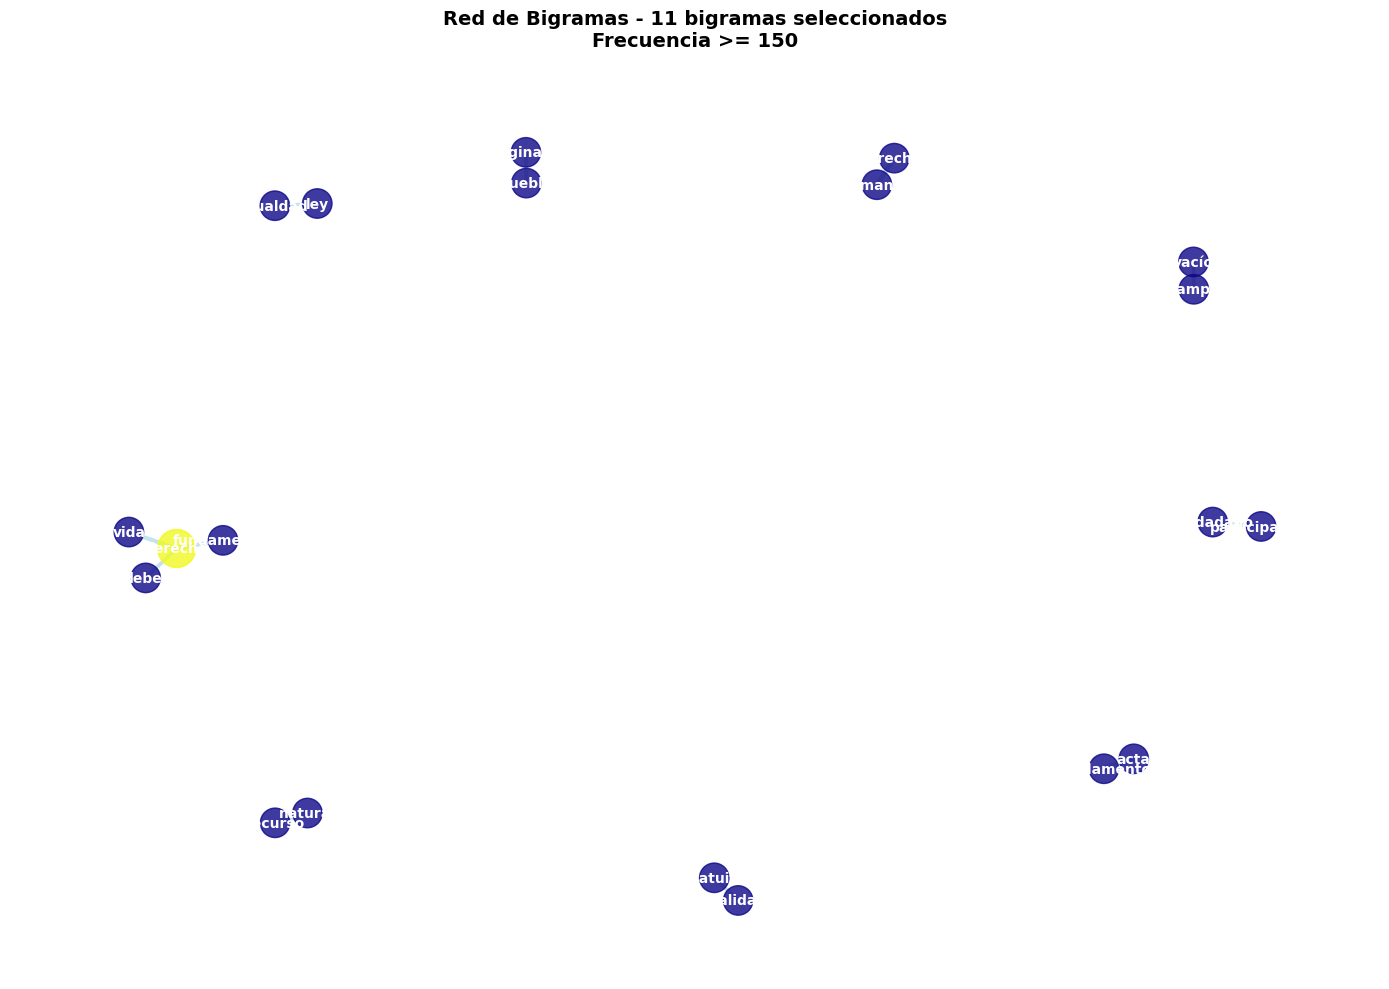


üìä Resultados:
  ‚Ä¢ Nodos: 20
  ‚Ä¢ Conexiones: 11
  ‚Ä¢ Densidad: 0.058

üéØ Configuraci√≥n 2: M√°s bigramas, frecuencia media
üîß Configuraci√≥n: Top 25 bigramas, frecuencia m√≠nima: 80


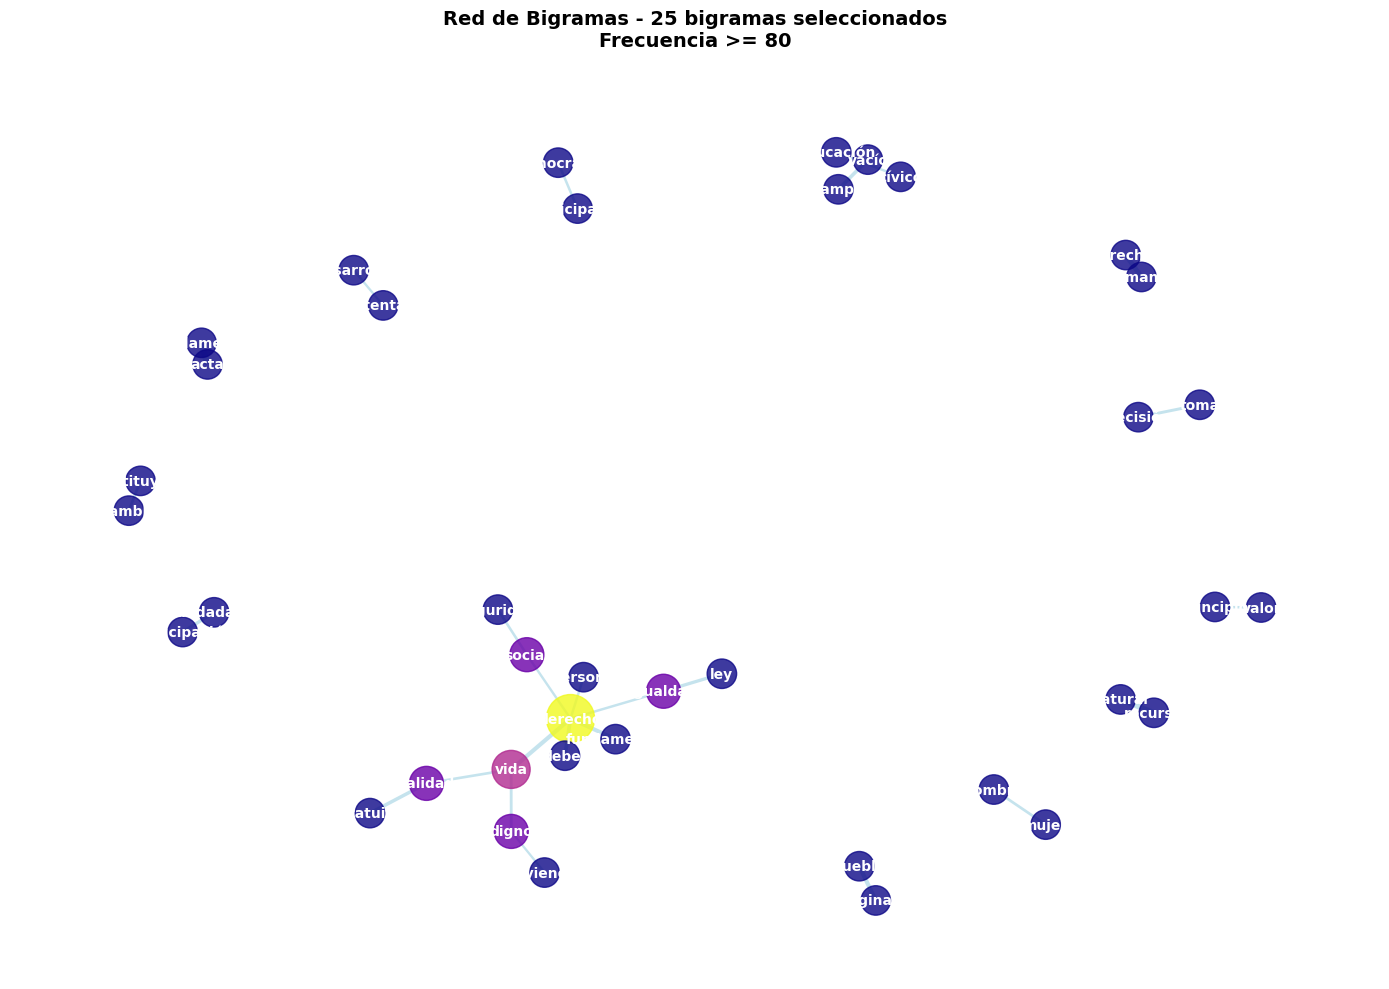


üìä Resultados:
  ‚Ä¢ Nodos: 39
  ‚Ä¢ Conexiones: 25
  ‚Ä¢ Densidad: 0.034


In [ ]:
def crear_grafo_bigramas(top_n=20, freq_minima=100, figsize=(14, 10)):
    """
    Funci√≥n para crear grafos de red con diferentes par√°metros
    
    Par√°metros:
    - top_n: n√∫mero de bigramas m√°s frecuentes a considerar
    - freq_minima: frecuencia m√≠nima para incluir un bigrama
    - figsize: tama√±o de la figura
    """
    print(f"üîß Configuraci√≥n: Top {top_n} bigramas, frecuencia m√≠nima: {freq_minima}")
    
    # Filtrar bigramas
    bigramas_filtrados = contador_bigramas.most_common(top_n)
    bigramas_validos = [(bg, count) for bg, count in bigramas_filtrados if count >= freq_minima]
    
    if not bigramas_validos:
        print(f"‚ùå No hay bigramas con frecuencia >= {freq_minima}")
        return
    
    # Crear grafo
    G = nx.Graph()
    for bigrama, count in bigramas_validos:
        try:
            palabras = bigrama.split()
            if len(palabras) == 2:
                a, b = palabras
                G.add_edge(a, b, weight=count)
        except ValueError:
            continue
    
    if G.number_of_nodes() == 0:
        print("‚ùå No se pudieron crear conexiones v√°lidas")
        return
    
    # Visualizar
    plt.figure(figsize=figsize)
    
    # Layout con mejor separaci√≥n
    pos = nx.spring_layout(G, k=2, iterations=100)
    
    # Tama√±os y colores din√°micos
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 150 + 300 for node in G.nodes()]
    
    # Centralidad para colores
    centrality = nx.degree_centrality(G)
    node_colors = [centrality[node] for node in G.nodes()]
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos,
                            node_size=node_sizes,
                            node_color=node_colors,
                            cmap=plt.cm.plasma,
                            alpha=0.8)
    
    # Etiquetas con mejor formato
    nx.draw_networkx_labels(G, pos,
                            font_size=10,
                            font_weight='bold',
                            font_color='white',
                            font_family='sans-serif')
    
    # Edges con grosor variable
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    
    nx.draw_networkx_edges(G, pos,
                            width=[w/max_weight * 4 + 0.5 for w in weights],
                            alpha=0.7,
                            edge_color='lightblue')
    
    plt.title(f'Red de Bigramas - {len(bigramas_validos)} bigramas seleccionados\n'
                f'Frecuencia >= {freq_minima}', 
                fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Estad√≠sticas
    print(f"\nüìä Resultados:")
    print(f"  ‚Ä¢ Nodos: {G.number_of_nodes()}")
    print(f"  ‚Ä¢ Conexiones: {G.number_of_edges()}")
    print(f"  ‚Ä¢ Densidad: {nx.density(G):.3f}")
    
    return G

# Probar diferentes configuraciones
print("üéØ Configuraci√≥n 1: Bigramas muy frecuentes")
G1 = crear_grafo_bigramas(top_n=15, freq_minima=150)

print("\n" + "="*50)
print("üéØ Configuraci√≥n 2: M√°s bigramas, frecuencia media")
G2 = crear_grafo_bigramas(top_n=25, freq_minima=80)

## üìà An√°lisis de los Grafos de Red

### ‚úÖ **Implementaci√≥n:**

1. **Filtrado por frecuencia**: Solo se muestran bigramas con alta frecuencia (>=50 o >=80)
2. **L√≠mite de bigramas**: Se seleccionan solo los Top 15-30 m√°s frecuentes
3. **Nodos din√°micos**: El tama√±o depende del n√∫mero de conexiones
4. **Colores por centralidad**: Los nodos m√°s conectados se destacan
5. **Bordes proporcionales**: El grosor representa la frecuencia del bigrama

### üîç **Insights principales:**

- **"derecho"** es la palabra m√°s central (7 conexiones)
- **Conceptos clave**: derechos humanos, recurso natural, pueblo originario
- **Densidad baja** (0.03-0.06): Indica conceptos espec√≠ficos y bien diferenciados
- **Clusters tem√°ticos**: Se forman grupos por tem√°ticas (derechos, recursos, participaci√≥n)

### üõ†Ô∏è **Recomendaciones para an√°lisis futuros:**

1. **Filtrar por regiones** para ver diferencias geogr√°ficas
2. **Analizar trigramas** para conceptos m√°s espec√≠ficos  
3. **Usar an√°lisis de comunidades** con `nx.community.greedy_modularity_communities()`
4. **Implementar m√©tricas de centralidad** m√°s avanzadas (betweenness, closeness)

### üìä **Par√°metros recomendados:**
- **Para an√°lisis general**: `freq_minima=80, top_n=25`
- **Para conceptos centrales**: `freq_minima=150, top_n=15`

## 6. Descripci√≥n del concepto